In [1]:
from devito import *
from AI4Advection_Diffusion import PDE_Solver
from examples.cfd import  plot_field
import numpy as np
import torch
import matplotlib.pyplot as plt
from filter.filter_generator import upwind, centre_difference,DA_eq

torch.Size([1, 1, 64, 64])


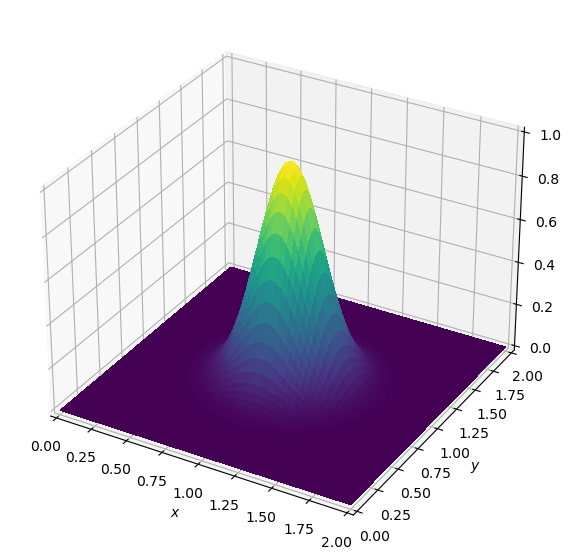

In [2]:

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.001  # Timestep size (sigma=0.2)
nx = 64
ny = 64
length = 2.


# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
v = TimeFunction(name='v', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor_init_ad = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor_init_ad[0,0,:,:].detach(),f'./advection_diffusion_equation_result/AD0.pt')
print(u_tensor_init_ad.shape)
plot_field(u.data[0])



In [3]:
D = 0.05
C = 0.5
eq1 = Eq(u.dt + C*u.dx + C*u.dy, D*u.laplace+v-u)
eq1

Eq(0.5*Derivative(u(time, x, y), x) + 0.5*Derivative(u(time, x, y), y) + Derivative(u(time, x, y), time), -u(time, x, y) + v(time, x, y) + 0.05*Derivative(u(time, x, y), (x, 2)) + 0.05*Derivative(u(time, x, y), (y, 2)))

In [4]:
model_adv = PDE_Solver(eq = eq1,u = u, dx = length/nx, dy = length/ny, nx = nx, ny = ny,dt = dt, solver = DA_eq, omega=1)
result = model_adv.forward(4)

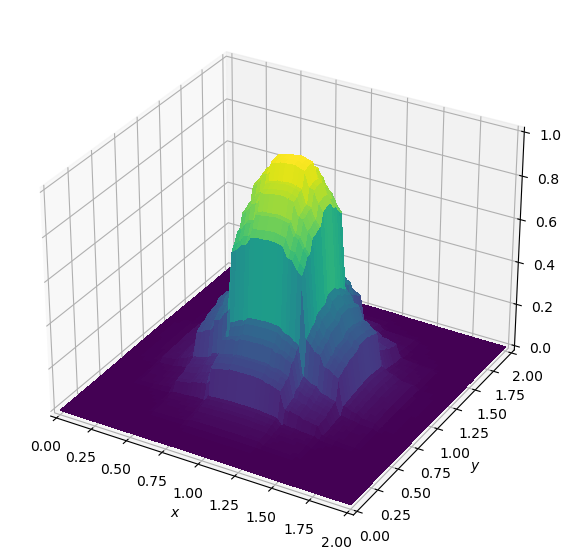

In [5]:

plot_field(result.data[4])


In [6]:
model_adv.A

tensor([[[[ 0.0000, -0.0513,  0.0000],
          [-0.0673,  0.0000, -0.0513],
          [ 0.0000, -0.0673,  0.0000]]]])

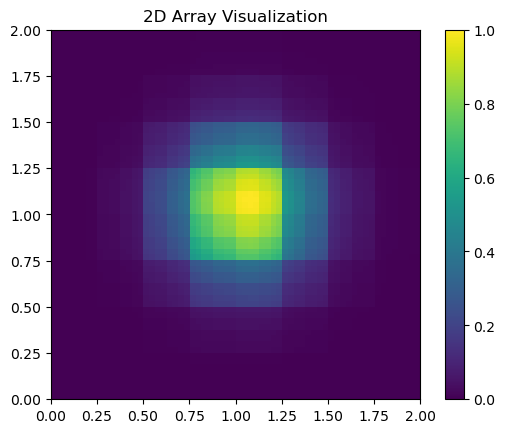

In [7]:
import matplotlib.pyplot as plt
test = torch.load('./advection_diffusion_equation_result/AD4.pt')

plt.imshow(test.numpy(), extent=(0, 2, 0, 2), origin='lower', cmap='viridis')
plt.colorbar()  
plt.title("2D Array Visualization")
plt.show()

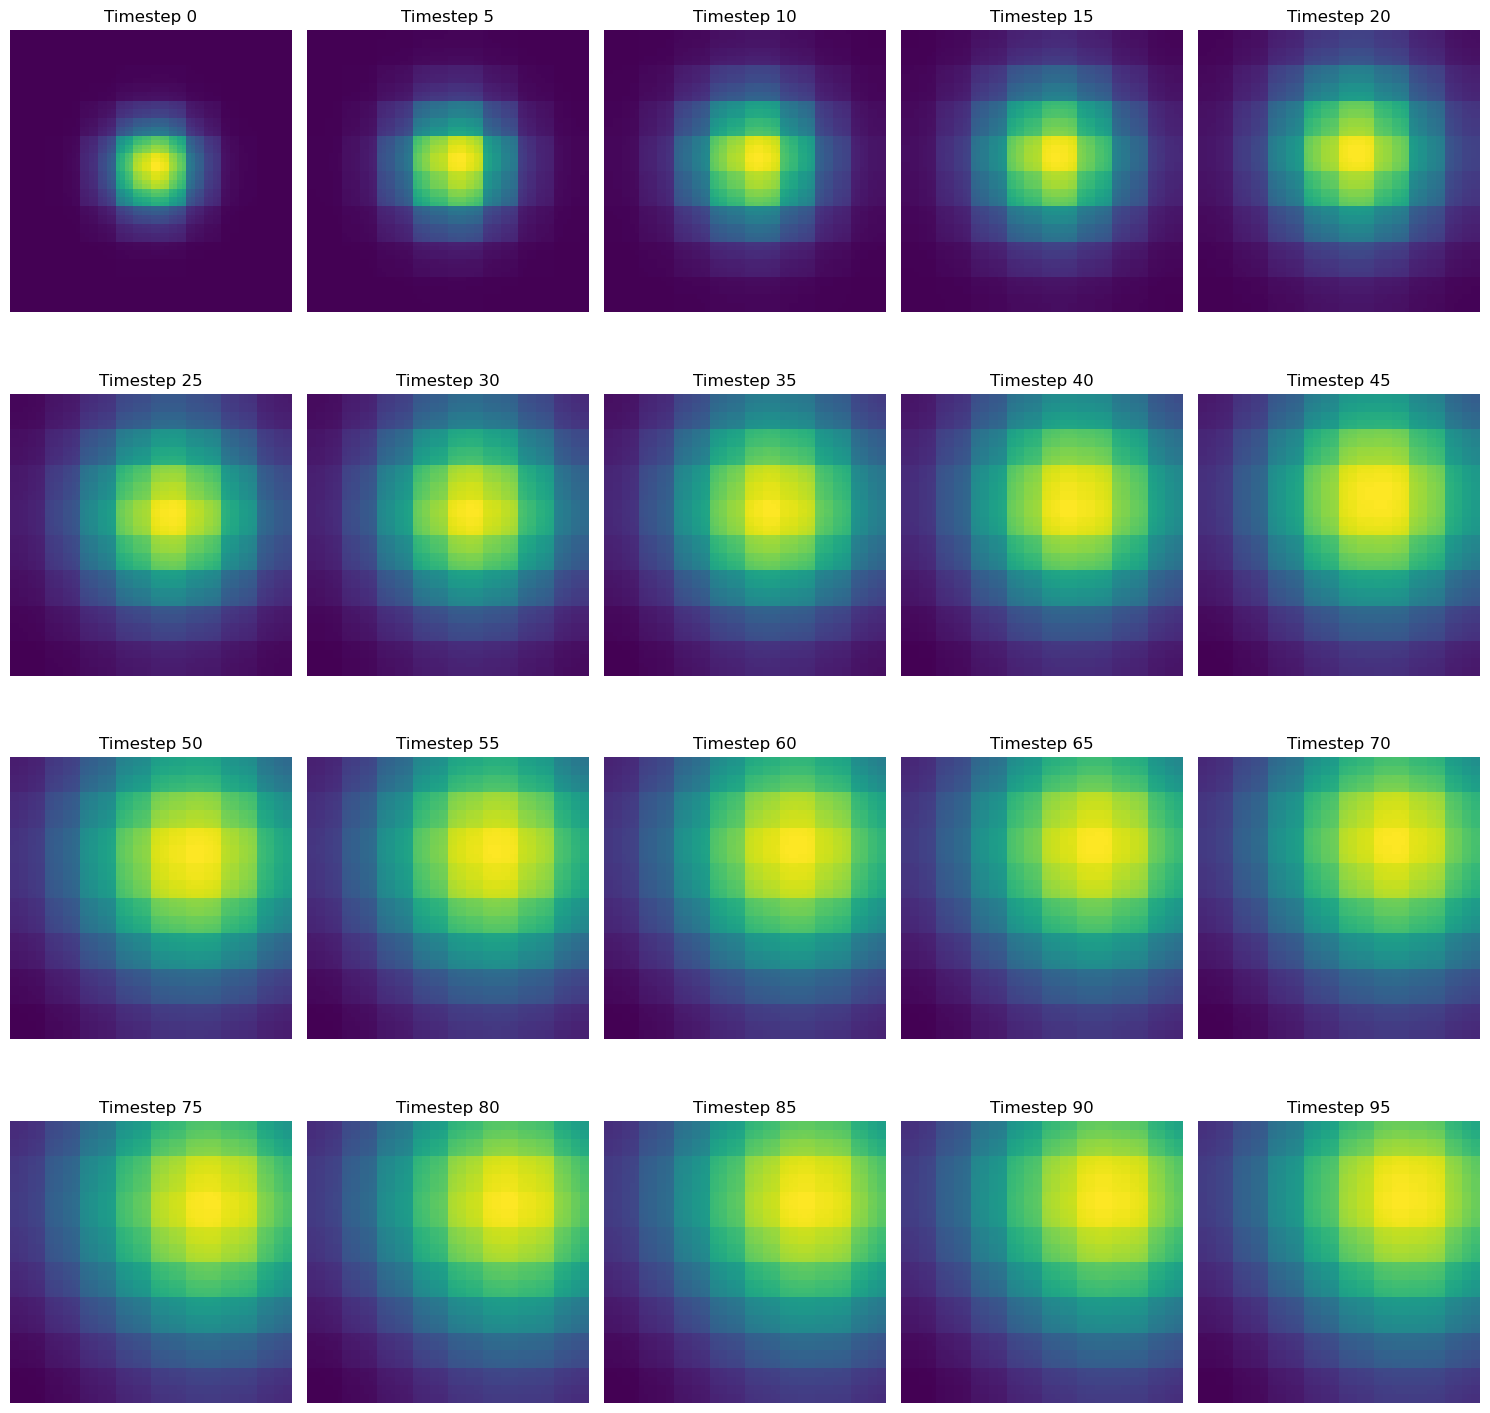

In [8]:
tensors = []
for i in range(1, nt, 5):
    tensor = torch.load(f'./advection_diffusion_equation_result//AD{i}.pt')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor.detach().numpy()
    ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()

In [9]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 加载张量数据
tensors = []
for i in range(1, nt):
    tensor = torch.load(f'./advection_diffusion_equation_result//AD{i}.pt')
    tensors.append(tensor)

# 创建动画
fig, ax = plt.subplots()
def update(frame):
    global cbar
    ax.clear()
    data = tensors[frame].detach().numpy()
    cax = ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {frame}')
    return cax

anim = FuncAnimation(fig, update, frames=len(tensors), interval=200, blit=False)

# 显示动画
plt.close(fig)  # 防止显示静态图
HTML(anim.to_jshtml())

In [10]:
len(u.data)

100

In [11]:
a = model_adv.A

In [12]:
u

u(time, x, y)

In [13]:
eq1.subs({u:u.forward, u.dx: (-u.forward.shift(x, -x.spacing) + u.forward)/dx})

NameError: name 'x' is not defined

In [ ]:
t,x,y = u.dimensions
z = sympy.symbols('z')
dx = 1
dy = 1
stencil_fd = eq1.subs({
    dt:1,
    u.dx: (-u.forward.shift(x, -x.spacing) + u.forward)/dx,  
    u.dy: (-u.forward.shift(y, -y.spacing) + u.forward)/dy,
    u.dx2: (u.forward.shift(x,x.spacing) - 2*u.forward + u.forward.shift(x, -x.spacing))/dx**2,
    u.dy2: (u.forward.shift(y,y.spacing) - 2*u.forward + u.forward.shift(y, -y.spacing))/dy**2,
    u.dt:z
    })


In [ ]:
stencil_fd.subs({u:u.forward, v:v.forward,u.forward.dt:u.dt, z:u.dt})

In [ ]:
f'{u.dt}' not in str(eq1)

In [ ]:
stencil_fd

In [ ]:
eq = Eq(u.dt + C*u.dx + C*u.dy, D*u.laplace)
solve(eq, u)

In [ ]:
eq